# 安裝套件

In [4]:
# install.packages("readxl")
# install.packages("xts") # For time series data handling
# install.packages("gmp")
# install.packages("rmgarch")

also installing the dependencies 'FNN', 'kernlab', 'mclust', 'multicool', 'pracma', 'ks', 'chron', 'fracdiff', 'nloptr', 'truncnorm', 'mvtnorm', 'rugarch', 'Rsolnp', 'ff', 'pcaPP', 'corpcor', 'RcppArmadillo'




package 'FNN' successfully unpacked and MD5 sums checked
package 'kernlab' successfully unpacked and MD5 sums checked
package 'mclust' successfully unpacked and MD5 sums checked
package 'multicool' successfully unpacked and MD5 sums checked
package 'pracma' successfully unpacked and MD5 sums checked
package 'ks' successfully unpacked and MD5 sums checked
package 'chron' successfully unpacked and MD5 sums checked
package 'fracdiff' successfully unpacked and MD5 sums checked
package 'nloptr' successfully unpacked and MD5 sums checked
package 'truncnorm' successfully unpacked and MD5 sums checked
package 'mvtnorm' successfully unpacked and MD5 sums checked
package 'rugarch' successfully unpacked and MD5 sums checked
package 'Rsolnp' successfully unpacked and MD5 sums checked
package 'ff' successfully unpacked and MD5 sums checked
package 'pcaPP' successfully unpacked and MD5 sums checked
package 'corpcor' successfully unpacked and MD5 sums checked
package 'RcppArmadillo' successfully unpa

# --- 1. 安裝和載入必要的套件 ---

In [2]:
library(rmgarch)
library(xts)
library(readxl)

Loading required package: rugarch

Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:rmgarch':

    first, last




In [3]:
# 讀取 Excel（預設讀取第一個工作表）
reserch_table <- read_excel("reserch_table_2515.xlsx")

In [4]:
head(reserch_table)         # 顯示前 6 筆資料

code,date,spot_return,futures_return,SVI,SVI_D1,SVI_D2,SVI_D3,d1_sr,d2_sr,d3_sr,d1_fr,d2_fr,d3_fr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2515,20171003,2.6356,2.5223,37,1,0,0,2.6356,0.000,0,2.5223,0.0000,0
2515,20171005,5.7560,6.0781,64,0,1,0,0.0000,5.756,0,0.0000,6.0781,0
2515,20171006,-2.0676,-2.5921,55,0,0,0,0.0000,0.000,0,0.0000,0.0000,0
2515,20171011,-3.1120,-2.1008,58,0,1,0,0.0000,-3.112,0,0.0000,-2.1008,0
2515,20171012,-0.8658,-1.1445,47,0,0,0,0.0000,0.000,0,0.0000,0.0000,0
2515,20171013,0.5780,-0.2894,45,0,0,0,0.0000,0.000,0,0.0000,0.0000,0


In [5]:
# 將數據轉換為 xts 時間序列對象 (rmgarch 需要)
# 報酬率數據
reserch_table$date <- as.Date(as.character(reserch_table$date), format = "%Y%m%d")
returns_xts <- xts(reserch_table[, c("spot_return", "futures_return")], order.by = reserch_table$date)

In [6]:
# 外生變數矩陣 (用於波動率模型)
# 論文 (5) 和 (6) 式: h_SS,t = ... + δ_S,F * ε_F,t-1^2 + δ_DS,F * (D_t * ε_F,t-1^2)
#                      h_FF,t = ... + δ_F,S * ε_S,t-1^2 + δ_DF,S * (D_t * ε_S,t-1^2)
# 這裡需要創建滯後的殘差平方項和它們與D的交互項
# 這一步比較複雜，因為 ε_F,t-1^2 和 ε_S,t-1^2 是模型內生的。
# 一種簡化的方法是，如果我們想讓 D 直接影響波動率水平，而不是通過與殘差的交互，
# 可以將 D_HighAttention 作為外生變數。
# 如果要嚴格複製論文，需要更複雜的設定，可能涉及到兩步法或自定義概似函數。


# 簡化版：假設 D_HighAttention 直接影響波動率 (作為 variance.targeting 的外生變數之一)
# 注意：rmgarch 中將外生變數直接加入 GARCH 項的交互作用比較困難，
# 通常外生變數加入到 variance equation (variance.regressors) 是線性的。
# 論文中的交互項 δ_DS,F * (D_t * ε_F,t-1^2) 形式更為複雜。

# 我們先創建 D_HighAttention 的 xts 對象
# 確保外生變數的日期與報酬率對齊
external_D_xts <- xts(reserch_table$SVI_D3, order.by = reserch_table$date)
colnames(external_D_xts) <- "D_High"

In [7]:
# 為了模擬論文中對方滯後殘差平方的影響 (例如 δ_S,F * ε_F,t-1^2)，
# 這在標準的 rmgarch 中直接設定比較困難，因為 ε_F,t-1^2 是模型的一部分。
# 通常這種跨變數的 GARCH 效應 (BEKK 模型的一種特例) 在 DCC 框架下不常見。
# 論文的模型結構非常特定。

# 妥協方案：我們先專注於不對稱性和 D 直接影響波動率。
# 如果要包含對方滯後殘差平方項，可能需要考慮更複雜的 BEKK 模型或自定義估計。


# --- 3. 定義單變量 GARCH 模型設定 ---
# 論文中 h_SS,t 包含標準 GARCH 項, 不對稱項 (ε_S,t-1^2 * I_S,t-1),
# 以及對方市場的波動影響和注意力交互項。
# 我們選用 gjrGARCH (對應 GJR-GARCH) 來捕捉不對稱性。
# model = "sGARCH" (標準 GARCH) 或 "gjrGARCH" (不對稱 GARCH)
# garchOrder = c(1,1) (p=1, q=1)

# 為 SR 設定單變量模型
# variance.model = list(model = "gjrGARCH", garchOrder = c(1,1),
#                       external.regressors = matrix(external_D_xts))
# 上述 external.regressors 會將 D_High 加入到波動率方程，但不是論文那種交互形式。

# 一個更接近論文的方法是，如果我們將 D_HighAttention 視為一個會改變 GARCH 參數的狀態。
# 但 rmgarch 不直接支持這種狀態轉換的 GARCH 參數。

# 讓我們嘗試將 D 作為一個外生回歸項加入到波動率方程中 (線性影響)
# 這與論文中的乘法交互項 (D * ε^2) 不同，但這是 rmgarch 較容易實現的。
uspec_sr <- ugarchspec(
  variance.model = list(model = "gjrGARCH", # 包含不對稱項
                        garchOrder = c(1, 1),
                        external.regressors = matrix(external_D_xts) # D 作為外生變數影響波動率
                        ),
  mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), # 假設 ARMA(0,0) 均值
  distribution.model = "norm" # 或 "std" (t分佈), "ged"
)

uspec_fr <- ugarchspec(
  variance.model = list(model = "gjrGARCH",
                        garchOrder = c(1, 1),
                        external.regressors = matrix(external_D_xts)
                        ),
  mean.model = list(armaOrder = c(0, 0), include.mean = TRUE),
  distribution.model = "norm"
)

In [8]:
# 將單變量設定組合成多變量設定
# 由於我們有兩隻股票 SR 和 FR
# 這裡假設對 SR 和 FR 使用相同的單變量模型結構 (但參數會分開估計)
# 如果要為每個序列用不同的外生變數，external.regressors 可以是一個列表
# 例如： external.regressors = list(matrix(D_for_SR), matrix(D_for_FR))
# 在這個例子中，我們假設 D_HighAttention 同時影響 SR 和 FR 的波動率
# 如果要實現論文中 h_SS,t 受 D*ε_F^2 影響，h_FF,t 受 D*ε_S^2 影響，
# 這需要更複雜的 external.regressors 結構，可能需要創建這些交互項作為新的外生變數列。
# 這一步通常是最 tricky 的，因為 ε 是模型估計出來的。

# 創建一個包含兩個單變量模型的列表 (如果模型結構相同)
# 或者分別創建 uspec_SR 和 uspec_FR
mspec <- multispec(replicate(2, uspec_sr)) # 假設 SR 和 FR 用相同的單變量模型結構

# --- 4. 定義多變量 DCC 模型設定 ---

In [10]:
# model = "DCC" 或 "aDCC" (不對稱 DCC)
# dccOrder = c(1,1)
# distribution = "mvnorm" (多元常態) 或 "mvt" (多元t)

dcc_spec <- dccspec(
  uspec = mspec, # 使用上面定義的單變量模型
  dccOrder = c(1, 1),
  distribution = "mvnorm", # 多元常態分佈
  model = "DCC" # 標準 DCC，如果需要不對稱 DCC，則用 "aDCC"
                # 論文中的不對稱性主要體現在單變量波動率方程中
)

# --- 5. 組合模型設定並進行估計 ---

In [11]:
# rmgarch 的估計過程通常是兩步法：
# 1. 估計單變量 GARCH 模型
# 2. 基於標準化殘差估計 DCC 參數

# 執行 DCC-GARCH 模型估計
# fit.control 中的 fixed.se=1 可能有助於某些情況下的收斂
# solver = "solnp" 是常用的優化器
print("Starting DCC-GARCH model estimation...")
dcc_fit <- dccfit(
  spec = dcc_spec,
  data = returns_xts,
  solver = "solnp", # 或者 "nlminb", "gosolnp"
  solver.control = list(trace = 1) # 顯示優化過程
  # fit.control = list(eval.se = TRUE) # 計算標準誤
)

# --- 6. 查看和解釋結果 ---
print(dcc_fit)

[1] "Starting DCC-GARCH model estimation..."

Iter: 1 fn: 337.1168	 Pars:   0.194302180632  0.082154160273  0.000000122657  0.999999974079 -0.057271432213  0.000000008359
Iter: 2 fn: 337.1168	 Pars:   0.194300918142  0.082154098366  0.000000100359  0.999999980926 -0.057271419114  0.000000007632
solnp--> Completed in 2 iterations

Iter: 1 fn: 345.3660	 Pars:   0.216033797493  0.110838245906  0.000000015495  0.999999989442 -0.070749686626  0.000000009617
Iter: 2 fn: 345.3660	 Pars:   0.216033958322  0.110838260722  0.000000014799  0.999999989797 -0.070749685210  0.000000009599
solnp--> Completed in 2 iterations

Iter: 1 fn: -17.9191	 Pars:  0.0000000001955 0.9084691818434
Iter: 2 fn: -17.9191	 Pars:  0.0000000001155 0.9084562124493
solnp--> Completed in 2 iterations

*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(1,1)
No. Parameters       :  15
[VAR GARCH DCC UncQ] : [

[spot_return].mu     [spot_return].omega    [spot_return].alpha1 
           1.943009e-01            8.215410e-02            1.003591e-07 
    [spot_return].beta1    [spot_return].gamma1    [spot_return].vxreg1 
           1.000000e+00           -5.727142e-02            7.632197e-09 
    [futures_return].mu  [futures_return].omega [futures_return].alpha1 
           2.160340e-01            1.108383e-01            1.479854e-08 
 [futures_return].beta1 [futures_return].gamma1 [futures_return].vxreg1 
           1.000000e+00           -7.074969e-02            9.598813e-09 
           [Joint]dcca1            [Joint]dccb1 
           1.155367e-10            9.084562e-01

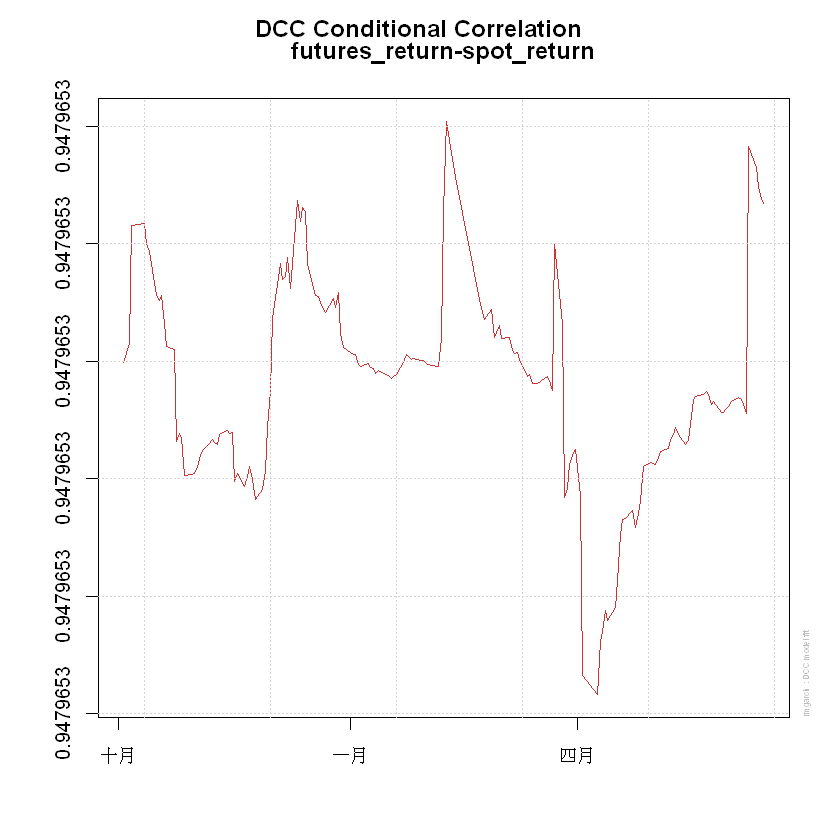

In [26]:
# 查看係數
coef(dcc_fit)

# 查看條件共變異數和相關性
# rcov(dcc_fit) # 條件共變異數矩陣序列
# rcor(dcc_fit) # 條件相關性矩陣序列

# 繪製條件相關性
plot(dcc_fit, which = 4) # 繪製動態條件相關性

# 模型的概似值
# likelihood(dcc_fit)